In [11]:
import numpy as np
import pandas as pd
import pickle 

from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist

def load_data(file):
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data)

def dump_data(data, filename):
    print('writing file: ' + filename)
    with open(filename, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def average_across_points(dat, window_size=10):
    dshape = dat['eeg'].shape

    new_length = dshape[-1] // window_size
    eeg_reshaped = dat['eeg'][:, :, :new_length * window_size].reshape(dshape[0], dshape[1], new_length, window_size)
    dat['eeg'] = eeg_reshaped.mean(axis=-1)
    dat['time'] = dat['time'][:new_length * window_size].reshape(new_length, window_size).mean(axis=-1)
    
    return dat

def separate_odd_even(indices):
    odd_numbers = []
    even_numbers = []

    for index in indices:
      
        if index % 2 == 0:
            even_numbers.append(index)
        else:
            odd_numbers.append(index)

    return np.array(odd_numbers), np.array(even_numbers)

def split_into_four(arr):

    split_size = len(arr) // 4
    

    part1 = arr[:split_size]
    part2 = arr[split_size:2*split_size]
    part3 = arr[2*split_size:3*split_size]
    part4 = arr[3*split_size:]
    
    return part1, part2, part3, part4

def upper(df):

    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [60]:
### Load Data
sub = 0
conditions_1 = ["fix", "img"]
conditions_2 = ["det", "rand"]
eye_chs = ['VEOG1', 'VEOG2', 'HEOG1','HEOG2']


img_nperms = 1
trial_lim = 312

edi_data = {}
for cond in conditions_1:
    for cond2 in conditions_2: 
        cond_name = "{}_{}".format(cond, cond2)
        edi_data[cond_name] = []

        ### Subsample data
        dat_name = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{:04d}_{}.pickle".format(sub, cond)
        dat = load_data(dat_name)
        dat = average_across_points(dat, window_size=10)
        
        ### Button press mask
        bt_press = dat["button_press_mask"]
        dat["eeg"] = dat["eeg"][~bt_press]
        dat["ids"] = dat["ids"][~bt_press]

        ### Select condition 
        image_labels = [1,2,3,4]
        if cond2 == "rand":
            image_labels = [im + 10 for im in image_labels]

        mask = np.isin(dat["ids"], image_labels)

        eeg_ = dat["eeg"][mask]
        ids_ = dat["ids"][mask]

        ### Select condition 
        image_labels = [1,2,3,4]
        if cond2 == "rand":
            image_labels = [im + 10 for im in image_labels]

        mask = np.isin(dat["ids"], image_labels)

        eeg_ = dat["eeg"][mask]
        ids_ = dat["ids"][mask]

        ### Get vars
        n_conditions = len(image_labels)
        n_sensors = eeg_.shape[1]
        n_time = eeg_.shape[-1]

        # DA matrix 
        TG_1 = np.full((n_conditions, n_conditions, n_time), np.nan)
        TG_2 = np.full((n_conditions, n_conditions, n_time), np.nan)

        ### Randomly pick 300 trials per conditoin  
        eeg_svm = np.full((len((np.unique(ids_))), trial_lim, eeg_.shape[1], eeg_.shape[2]), np.nan)


        for p in tqdm(range(img_nperms)):
            for idx, x in enumerate(np.unique(ids_)):
                total_num_trials = len(ids_[ids_ == x])

                # Define the range
                range_array = np.arange(0, total_num_trials)

                # Pick x random idx without repetition
                random_numbers = np.random.choice(range_array, trial_lim, replace=False)

                # Select
                eeg_svm[idx, :, :, :] = eeg_[ids_== x][random_numbers, :, :]

            set1, set2, set3, set4 = split_into_four(np.arange(0, trial_lim))
            eeg_set1 = eeg_svm[:, set1, :, :] 
            eeg_set2 = eeg_svm[:, set2, :, :]
            eeg_set3 = eeg_svm[:, set3, :, :]
            eeg_set4 = eeg_svm[:, set4, :, :]

            ### calculate RDMs - Mahlanobis distance
            for cA in range(n_conditions):
                for cB in range(cA, n_conditions):
                    for t in range(n_time):
                        cA_values = eeg_set1[cA,:,:,t]
                        cB_values = eeg_set2[cB,:,:,t]

                        mah_dist = np.mean(cdist(cA_values, cB_values, 'mahalanobis'))
                        TG_1[cA,cB,t] = np.nansum(np.array((TG_1[cA,cB,t], mah_dist)))
                        
                        cA_values = eeg_set3[cA,:,:,t]
                        cB_values = eeg_set4[cB,:,:,t]

                        mah_dist = np.mean(cdist(cA_values, cB_values, 'mahalanobis'))
                        TG_2[cA,cB,t] = np.nansum(np.array((TG_2[cA,cB,t], mah_dist)))


        TG_1 = TG_1 / img_nperms
        TG_2 = TG_2 / img_nperms
        edi_data[cond_name].append(TG_1)
        edi_data[cond_name].append(TG_2)
        

#dump_data(edi_data, "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_reliability{:04d}.pickle".format(sub))

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0000_fix.pickle


  0%|          | 0/1 [00:00<?, ?it/s]

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0000_fix.pickle


  0%|          | 0/1 [00:00<?, ?it/s]

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0000_img.pickle


  0%|          | 0/1 [00:00<?, ?it/s]

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0000_img.pickle


  0%|          | 0/1 [00:00<?, ?it/s]

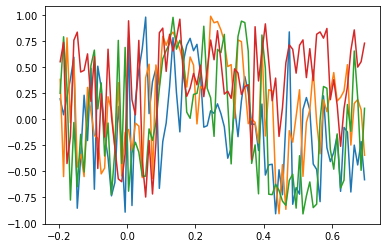

In [61]:
import matplotlib.pyplot as plt
for cond_name in edi_data.keys():
    vec = []
    for t in range(len(dat["time"])):
        vec.append(np.corrcoef(upper(edi_data[cond_name][0][:, :, t]), upper(edi_data[cond_name][1][:, :, t]))[0, 1])
    plt.plot(dat["time"], vec, label = "cond_name")

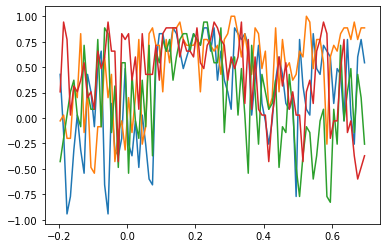

In [31]:
import matplotlib.pyplot as plt
from scipy import stats
for cond_name in edi_data.keys():
    vec = []
    for t in range(len(dat["time"])):
        vec.append(stats.spearmanr(upper(edi_data[cond_name][0][:, :, t]), upper(edi_data[cond_name][1][:, :, t]))[0])
    plt.plot(dat["time"], vec, label = "cond_name")

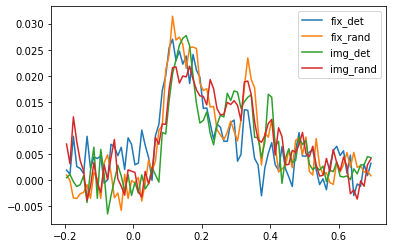

In [62]:
import matplotlib.pyplot as plt
for key in edi_data.keys():
    edi_time = []
    for t in range(n_time):
        edi_time.append(np.mean(upper(edi_data[key][0][:, :, t])) - np.mean(np.diagonal(edi_data[key][0][:, :, t])))
    plt.plot(dat["time"], edi_time, label = key)

plt.legend()

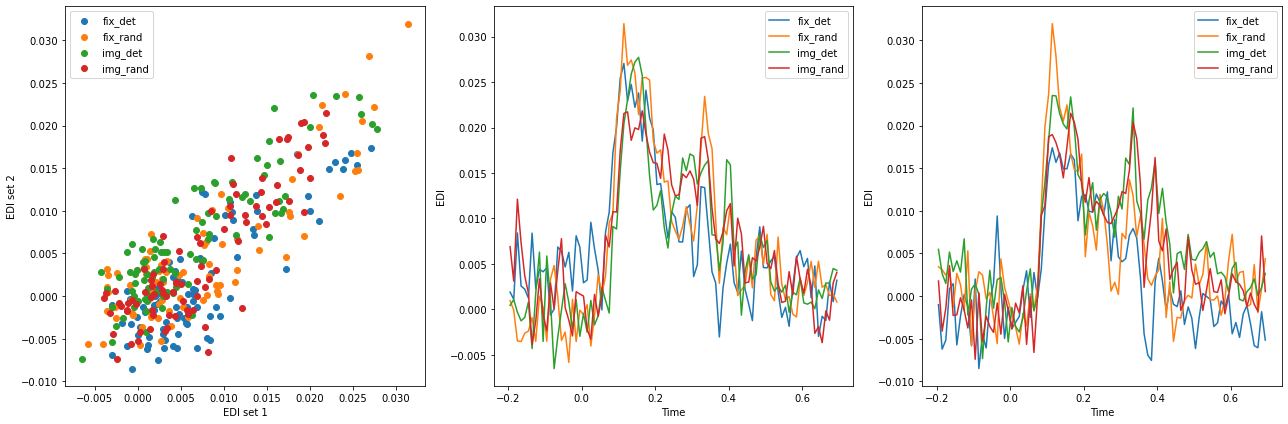

In [63]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create 1 row and 3 columns of subplots

# First plot: Scatter plot of EDI set 1 vs EDI set 2
for key in edi_data.keys():
    edi_time_1 = []
    edi_time_2 = []
    for t in range(n_time):
        edi_time_1.append(np.mean(upper(edi_data[key][0][:, :, t])) - np.mean(np.diagonal(edi_data[key][0][:, :, t])))
        edi_time_2.append(np.mean(upper(edi_data[key][1][:, :, t])) - np.mean(np.diagonal(edi_data[key][1][:, :, t])))
    axs[0].scatter(edi_time_1, edi_time_2, label=key)
    
axs[0].set_xlabel("EDI set 1")
axs[0].set_ylabel("EDI set 2")
axs[0].legend()

# Second plot: Line plot of EDI over time for the first set
for key in edi_data.keys():
    edi_time = []
    for t in range(n_time):
        edi_time.append(np.mean(upper(edi_data[key][0][:, :, t])) - np.mean(np.diagonal(edi_data[key][0][:, :, t])))
    axs[1].plot(dat["time"], edi_time, label=key)

axs[1].set_xlabel("Time")
axs[1].set_ylabel("EDI")
axs[1].legend()

# Third plot: Line plot of EDI over time for the second set
for key in edi_data.keys():
    edi_time = []
    for t in range(n_time):
        edi_time.append(np.mean(upper(edi_data[key][1][:, :, t])) - np.mean(np.diagonal(edi_data[key][1][:, :, t])))
    axs[2].plot(dat["time"], edi_time, label=key)

axs[2].set_xlabel("Time")
axs[2].set_ylabel("EDI")
axs[2].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()


In [33]:
plt.scatter(edi_time_1, edi_time_2)

NameError: name 'edi_time_1' is not defined

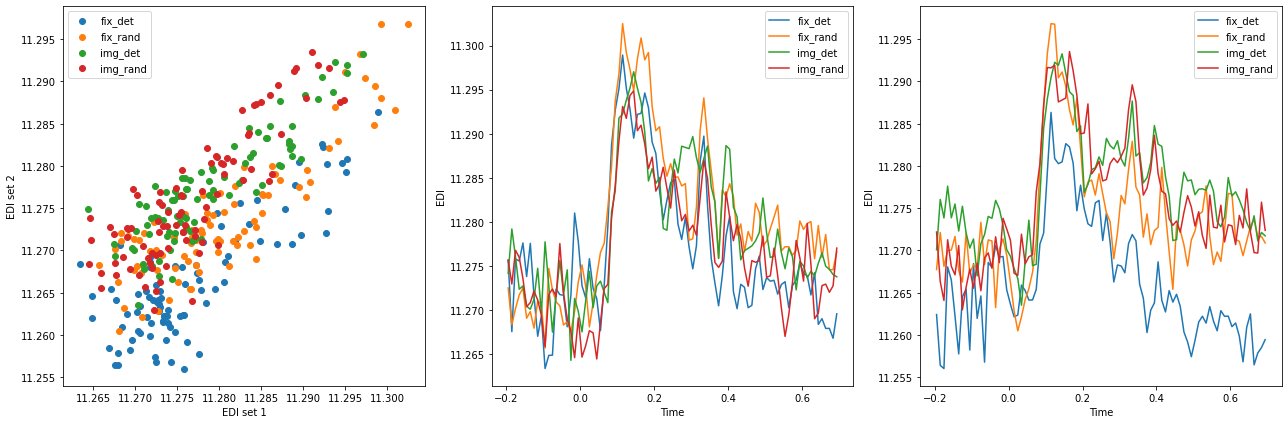

In [64]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create 1 row and 3 columns of subplots

# First plot: Scatter plot of EDI set 1 vs EDI set 2
for key in edi_data.keys():
    edi_time_1 = []
    edi_time_2 = []
    for t in range(n_time):
        edi_time_1.append(np.mean(upper(edi_data[key][0][:, :, t])))
        edi_time_2.append(np.mean(upper(edi_data[key][1][:, :, t])))
    axs[0].scatter(edi_time_1, edi_time_2, label=key)
    
axs[0].set_xlabel("EDI set 1")
axs[0].set_ylabel("EDI set 2")
axs[0].legend()

# Second plot: Line plot of EDI over time for the first set
for key in edi_data.keys():
    edi_time = []
    for t in range(n_time):
        edi_time.append(np.mean(upper(edi_data[key][0][:, :, t])))
    axs[1].plot(dat["time"], edi_time, label=key)

axs[1].set_xlabel("Time")
axs[1].set_ylabel("EDI")
axs[1].legend()

# Third plot: Line plot of EDI over time for the second set
for key in edi_data.keys():
    edi_time = []
    for t in range(n_time):
        edi_time.append(np.mean(upper(edi_data[key][1][:, :, t])))
    axs[2].plot(dat["time"], edi_time, label=key)

axs[2].set_xlabel("Time")
axs[2].set_ylabel("EDI")
axs[2].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()

In [43]:
edi_array = np.array(edi_data)

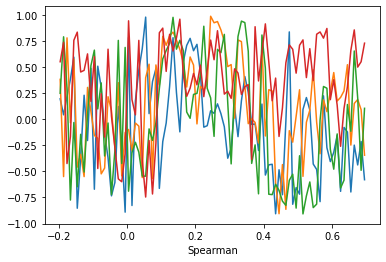

In [67]:
all_cond = []
for key in edi_data.keys():
    get_spearman = []
    for t in range(len(dat["time"])):
        get_spearman.append(np.corrcoef(upper(edi_data[key][0][:, :, t]), upper(edi_data[key][1][:, :, t]))[0, 1])
    all_cond.append(get_spearman)

    plt.plot(dat["time"],  get_spearman, label = key)
plt.xlabel("Spearman")
plt.show()

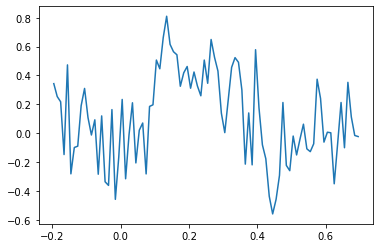

In [68]:
cond_mean = np.mean(np.array(all_cond), axis = 0)
plt.plot(dat["time"], cond_mean)

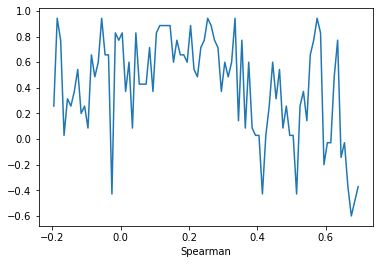

In [55]:
get_spearman = []
for t in range(len(dat["time"])):
    get_spearman.append(stats.spearmanr(upper(edi_data[key][0][:, :, t]), upper(edi_data[key][1][:, :, t]))[0])

plt.plot(dat["time"],  get_spearman, label = key)
plt.xlabel("Spearman")
plt.show()